# Tornado Alley Climate Model

Here we take general climatic information as well as a dataset of all tornadoes in the US, building a model to use the former to predict some aspects of the distribution of the latter.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
states = gpd.read_file('cb_2024_us_state_5m.zip')
states_to_remove = ['VI', 'MP', 'AK','HI','PR','AS', 'GU']
states = states[~states['STUSPS'].isin(states_to_remove)]

## Code to Create Training Data

### Interpolation for Missing Data

Most climate stations do not report values for all of the features. In order to obtain values for those missing features, we'll need to interpolate between the values at stations that report them.

In [3]:
from scipy.interpolate import LinearNDInterpolator

def linear_feature_interpolator(data,lat_feature,lon_feature,interp_feature:str):
    """
        Given a dataframe data, performs linear interpolation of the feature named interp_feature (a string). 
            lat_feature and lon_feature are strings giving the name of the features describing latitude and longitude.

            Values of interp_feature which are not NaN are associated with the corresponding latitude and longitude, and interpolation connects these values.
    
        Outputs a dataframe with the same size and contents as data, except in the feature interp_feature, 
        any values which are presently NaN are replaced with the value obtained from the interpolation procedure.
    """
    non_NaN_data = data[[lat_feature,lon_feature,interp_feature]][~data[interp_feature].isna()]
    interp = LinearNDInterpolator(non_NaN_data[[lat_feature,lon_feature]],non_NaN_data[interp_feature])

    data.loc[:,interp_feature] = interp(data[lat_feature],data[lon_feature])

    return data

def linear_multiple_feature_interpolator(data,lat_feature,lon_feature,interp_features:list):
    '''
         Interpolates the values separately for each feature in interp_features, one at a time.
    '''
    for feature in interp_features:
        data = linear_feature_interpolator(data,lat_feature,lon_feature,feature)

    return data

def multiyear_linear_feature_interpolator(data,lat_feature,lon_feature,interp_features:list,year_feature, years:list):
    '''
        Interpolates the values for each feature in interp_features, for each year in years.
        year_feature is a string giving the label of the column of data in which the year is stored.
    '''

    for year in years:
        year_df = data[data[year_feature] == year]
        year_df = linear_multiple_feature_interpolator(year_df,lat_feature,lon_feature,interp_features)
    
        data.loc[year_df.index] = year_df

        #print(str(year) + ' completed')
    
    return data
    


In [4]:
def remove_nans_interpolator(data,lat_feature,lon_feature,interp_features,year_feature,years:list):
    '''
        Given the dataset, removes all NaN entries for the given features using interpolation, 
        then subsequently removing any values still missing.
    '''
    data = multiyear_linear_feature_interpolator(data,lat_feature,lon_feature,interp_features,year_feature,years)

    for feature in features_to_interpolate:
        data = data[~data[feature].isnull()]

    return data

### Creating the Testing and Training Sets

We'll need to separate our data for training and testing our model. This is made somewhat tricky by the fact that most (almost all) weather stations do not report values for all of our attributes, so that values of attributes will need to be determined by interpolation. As such, we'll be doing the following:
* The years 1980-1989 and 2020-2024, inclusive, are to be designated as testing years. All data from these years will be set aside.
* Of the remaining data, a random 20% from each year will be set aside as a further testing set.
* We'll perform cross-validation on the data which remains. The data will be divided so as to ensure that no year has so much data removed from it so as to render interpolation inaccurate.

In [35]:
def create_testing_year_data_split(data, test_years, features_to_interpolate):
    '''
        Isolates all data from the specified list of the years in the given climate dataframe. 
        That data is set as a test set, with the remaining data set as a corresponding training set.
        Following that, missing values for the specified features are filled in by interpolation.
    '''
    test_year_df = data[data['DATE'].isin(test_years)]
    test_year_df = remove_nans_interpolator(data, 'LATITUDE','LONGITUDE', features_to_interpolate,'DATE',test_years)

    train_year_df = data[~data['DATE'].isin(test_years)]
    train_year_df = remove_nans_interpolator(train_year_df, 'LATITUDE','LONGITUDE', features_to_interpolate,'DATE',train_year_df['DATE'].unique())

    return (train_year_df,test_year_df)

In [6]:
from sklearn.model_selection import train_test_split

def create_random_test_data_split(data,features_to_interpolate,fraction,random_state,stratify_label):
    '''
        For every year represented in the data, an amount of data equal to the corresponding fraction of that year's data
        is set aside as a test set, with the remaining data forming a corresponding training set.
            stratify_label is a string representing the column label for the classification column in the data, 
                with the split preserving the ratio of data in each classification category.
        Following that, missing values for the specified features are filled in by interpolation.
    '''
    yearly_test_data = []
    yearly_train_data = []
    for year in data['DATE'].unique():
        year_df = data[data['DATE'] == year]
        train, test = train_test_split(year_df, test_size=fraction, random_state=year*random_state,stratify=year_df[stratify_label])
        yearly_train_data.append(train)
        yearly_test_data.append(test)

    test_rand_df = pd.concat(yearly_test_data)
    train_rand_df = pd.concat(yearly_train_data)

    return (train_rand_df, test_rand_df)

In [37]:
from sklearn.model_selection import StratifiedKFold

def create_cross_validation_data_split(data,features_to_interpolate,num_sets,random_state):
    '''
        Splits the data into training and testing sets for cross_validation.
    '''
    kfold = StratifiedKFold(n_splits=num_sets,shuffle=True,random_state=random_state)

    train_indices = []
    test_indices = []
    for train_index,test_index in kfold.split(data,data['tornado_alley']):
        train_indices.append(train_index)
        test_indices.append(test_index)


    years = data['DATE'].unique()
    train_dfs = []
    test_dfs = []
    for i in range(num_sets):
        #print("Creating dataset " + str(i))
        train_data = data.iloc[train_indices[i]]
        train_data = remove_nans_interpolator(train_data, 'LATITUDE','LONGITUDE', features_to_interpolate,'DATE',years)
        train_dfs.append(train_data)

        test_data = data.iloc[test_indices[i]]
        test_data = remove_nans_interpolator(test_data, 'LATITUDE','LONGITUDE', features_to_interpolate,'DATE',years)
        test_dfs.append(test_data)

    return (train_dfs, test_dfs)

In [8]:
def create_all_test_train_splits(data,features_to_interpolate,test_years,rand_data_fraction,num_cv_splits,random_state1,random_state2):
    '''
        Given the input dataframe and the list of features for which interpolation is required, outputs training and testing splits of
        each of the desired types.
        Output is of the form
            (train_year_df,test_year_df,train_rand_df,test_rand_df,train_cv_dfs,test_cv_dfs)
            with the first two representing a split by year, the second two representing a random subset of each year's data, 
            and the third containing splits for use in cross validation.
    '''
    print('Creating Specified Year Train-Test Split')
    train_year_df,test_year_df = create_testing_year_data_split(data,test_years,features_to_interpolate)

    remaining_df = data[~data['DATE'].isin(test_years)]

    print('Creating Randomized Train-Test Split')
    train_rand_df,test_rand_df = create_random_test_data_split(remaining_df,features_to_interpolate,rand_data_fraction,random_state1,'tornado_alley')

    remaining_df = remaining_df[remaining_df.index.isin(train_rand_df.index)]

    print('Creating Cross Validation Data Splits')
    train_cv_dfs, test_cv_dfs = create_cross_validation_data_split(data,features_to_interpolate,num_cv_splits,random_state2)

    return (train_year_df,test_year_df,train_rand_df,test_rand_df,train_cv_dfs,test_cv_dfs)

When we do cross validation, after splitting the sets we perform interpolation on each of our sets. As such, the dataset is changed beyond a simple choice of indices, breaking scikit-learn's cross-val-score function. As such, we need our own.

In [9]:
def cross_val_score_custom(estimator,train_cv_dfs,test_cv_dfs,scoring_metric,features):
    '''
        Given an estimator and two lists of dataframes of equal length representing the training and testing data for cross validation, 
        as well as a scoring metric, outputs a list of scores for each cross validation set.
    '''
    scores = []
    for i in range(len(train_cv_dfs)):
        train_data = train_cv_dfs[i]
        test_data = test_cv_dfs[i]

        estimator.fit(train_data[features],train_data['tornado_alley'])
        results = estimator.predict(test_data[features])

        scores.append(scoring_metric(test_data['tornado_alley'],results))

    return scores

It's useful for us to have a way at the ready to check that our data covers the US sufficiently well in any given year, since if it fails to do so, our interpolation is likely to introduce significant errors.

In [10]:
def data_per_year_count(data):
    '''
        Outputs a list of tuple pairs of integers. In each tuple, the first entry is the year, and the second the number of datapoints present in data for that year.
        Sorts the output list by the second value in each tuple.
    '''
    data_per_year = [(year,data[data['DATE'] == year].shape[0]) for year in data['DATE'].unique()]
    data_per_year = sorted(data_per_year, key = lambda x: x[1])

    return data_per_year

## Setting Up Statistical Tests

Here we'll set up some standardized code to implement different approaches to classification problems, to be applied in the subsequent section of the notebook.

### Importing Data and Selecting Feature Columns

In [11]:
climate_df = pd.read_csv('yearly_climate_data.csv')

climate_df

,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,CDSD,CLDD,DP01,DP10,DP1X,...,TAVG,TMAX,TMIN,DSND,DSNW,EMSD,EMSN,SNOW,DYFG,DYTS
0,2009,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",184.3,184.3,115.0,54.0,1.0,...,6.26,12.07,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",344.1,344.1,95.0,61.0,7.0,...,7.32,12.91,1.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",370.3,370.3,98.0,52.0,5.0,...,7.12,13.00,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",538.1,538.1,NaN,NaN,NaN,...,9.75,16.33,3.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",366.8,366.8,120.0,41.0,3.0,...,6.34,12.06,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689112,2020,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",598.1,598.1,84.0,53.0,4.0,...,11.14,17.23,5.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
689113,2021,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",668.7,668.7,73.0,45.0,11.0,...,11.71,17.83,5.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
689114,2022,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",724.6,724.6,73.0,40.0,6.0,...,11.04,18.11,3.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN
689115,2023,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",662.8,662.8,79.0,49.0,6.0,...,11.93,18.53,5.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
test_years = list(range(1980,1990)) + list(range(2020,2025))

features_to_interpolate = climate_df.columns[5:-1]
redundant_features = ['CDSD','HDSD','TAVG']
special_attributes = ['EMNT', 'EMXP', 'EMXT', 'EMSD', 'EMSN'] # The attributes for these features have extra, and potentially useful, information that we would need to handle with some care
date_features = ['FZF0', 'FZF1', 'FZF2', 'FZF3', 'FZF4', 'FZF5', 'FZF6', 'FZF7', 'FZF8', 'FZF9'] # The values for these features are dates, so we would need to handle them separately
features_to_interpolate = features_to_interpolate.drop(redundant_features)
features_to_interpolate = features_to_interpolate.drop(special_attributes)
features_to_interpolate = features_to_interpolate.drop(date_features)

reduced_climate_df = pd.concat([climate_df[['DATE','LATITUDE','LONGITUDE','ELEVATION','NAME']],climate_df[features_to_interpolate]],axis=1)


features_to_interpolate = list(features_to_interpolate)
features_to_interpolate

['CLDD',
 'DP01',
 'DP10',
 'DP1X',
 'DT00',
 'DT32',
 'DX32',
 'DX70',
 'DX90',
 'HTDD',
 'PRCP',
 'TMAX',
 'TMIN',
 'DSND',
 'DSNW',
 'SNOW',
 'DYFG']

### Some Basic Scikit-Learn Infrastructure

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

features = features_to_interpolate

classifiers = []

### KNN

EDA suggests a KNN might be feasible for classifying this data.

In [15]:
from sklearn.neighbors import KNeighborsClassifier

### Logistic Regression

There is relatively little evidence in EDA to suggest a linear decision boundary, but it seems worthwhile to at least attempt logistic regression regardless.

In [16]:
from sklearn.linear_model import LogisticRegression



### Linear SVM Classifier

EDA doesn't seem to point to a linear decision boundary, so skepticism is warranted about the viability of a linear SVM.

In [17]:
from sklearn.svm import LinearSVC



### Kernel SVM Classifier

EDA does suggest that a nonlinear decision boundary may have more success.

In [46]:
from sklearn.kernel_approximation import RBFSampler

### Decision Tree Classifiers

In [19]:
from sklearn import tree



### Random Forest Classifiers

In [20]:
from sklearn.ensemble import RandomForestClassifier



### Gradient Boosting Classifiers

In [21]:
from sklearn.ensemble import HistGradientBoostingClassifier



## A Gaussian Definition of Tornado Alley

In this section we'll take our definition of Tornado Alley to be based on a Gaussian model of tornado distribution. As such, we'll take the mean tornado position per year and select an elliptical region around that mean with size and shape determined by the covariance matrix of the tornado distribution for that year.

### Defining Tornado Alley in Each Year

In [22]:
tornado_df = pd.read_csv('all_tornadoes.csv')
# There are a very small subset (about 35) of strong tornadoes not having longitude or latitude values. These are removed now.
tornado_df = tornado_df[~tornado_df['begin_lat'].isnull()]
tornado_df = tornado_df[~tornado_df['begin_lon'].isnull()]

# Now, we also restrict ourselves to only working with strong tornadoes.
tornado_df = tornado_df[tornado_df['tor_f_scale'].isin(['F3','F4','F5'])]

# We remove unnecessary columns for this analysis.
tornado_df = tornado_df[['begin_lat','begin_lon','year']]
tornado_df

,begin_lat,begin_lon,year
0,35.1200,-99.2000,1950
6,40.2000,-76.1200,1950
7,40.2700,-76.0700,1950
16,34.8800,-99.2800,1950
17,35.0000,-99.2000,1950
...,...,...,...
75183,31.3773,-90.8606,2024
75270,35.3640,-97.4380,2024
75277,34.2910,-97.9690,2024
75288,35.4000,-97.2420,2024


We create a dataframe to store some basic statistical information about the data. We'll define variables so that the covariance matrix of the data we compute is
$$ \begin{bmatrix} covlat & covlatlon \\ covlatlon & covlon \end{bmatrix} $$
When we compute the covariance matrix, we'll only include the 90% of the data closest to the mean. This is to exclude tornadoes which occur in other portions of the US, usually related to other types of storms which we do not wish to include in our model.

In [23]:
years = tornado_df['year'].unique()

tornado_stat_df = pd.DataFrame(columns=['year','mean_lat','mean_lon','cov_lat','cov_lon','cov_latlon'])
for year in years:
    year_df = tornado_df[tornado_df['year']==year]

    mean_lat = year_df['begin_lat'].mean()
    mean_lon = year_df['begin_lon'].mean()

    year_df.loc[:,'dist_from_center'] = np.sqrt((year_df['begin_lat'] - mean_lat)**2 + (year_df['begin_lon'] - mean_lon)**2)
    threshold = year_df['dist_from_center'].quantile(.9)
    year_df = year_df[year_df['dist_from_center'] <= threshold]

    covar = year_df[['begin_lat','begin_lon']].cov()
    cov_lat = covar.loc['begin_lat','begin_lat']
    cov_lon = covar.loc['begin_lon','begin_lon']
    cov_latlon = covar.loc['begin_lat','begin_lon']

    tornado_stat_df.loc[year] = [year,mean_lat,mean_lon,cov_lat,cov_lon,cov_latlon]

tornado_stat_df


C:\Users\Matthew Dannenberg\AppData\Local\Temp\ipykernel_4744\1387820656.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df.loc[:,'dist_from_center'] = np.sqrt((year_df['begin_lat'] - mean_lat)**2 + (year_df['begin_lon'] - mean_lon)**2)
C:\Users\Matthew Dannenberg\AppData\Local\Temp\ipykernel_4744\1387820656.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df.loc[:,'dist_from_center'] = np.sqrt((year_df['begin_lat'] - mean_lat)**2 + (year_df['begin_lon'] - mean_lon)**2)
C:\Users\Matthew D

,year,mean_lat,mean_lon,cov_lat,cov_lon,cov_latlon
1950,1950.0,36.701333,-92.945778,15.544754,13.702657,3.055072
1951,1951.0,39.026061,-92.938485,21.381032,20.461056,2.641698
1952,1952.0,36.977536,-91.120580,12.231035,18.653245,-6.918728
1953,1953.0,37.988113,-89.820189,23.484266,29.344480,5.194767
1954,1954.0,35.953014,-93.663014,14.769522,15.243130,-1.142317
...,...,...,...,...,...,...
2020,2020.0,33.791325,-87.289428,2.820661,16.510193,2.779976
2021,2021.0,36.603379,-87.711998,7.631079,3.673312,-1.925205
2022,2022.0,34.430604,-91.313226,7.824557,27.268560,-4.791679
2023,2023.0,36.062547,-88.744887,8.731468,23.725347,0.117609


In [24]:
def tornado_alley_definer_gaussian(year,position,radius):
    '''
        Given the year and a specified latitude and longitude (an np array defining the position), 
        outputs 1 if the specified point lies within Tornado Alley, and a 0 otherwise.
        The positive float radius is a parameter reflecting the size of the ellipse representing Tornado Alley.
    '''
    difference = position - np.array([tornado_stat_df.loc[year,'mean_lon'],tornado_stat_df.loc[year,'mean_lat']])
    covar = np.array([[tornado_stat_df.loc[year,'cov_lon'],tornado_stat_df.loc[year,'cov_latlon']],[tornado_stat_df.loc[year,'cov_latlon'],tornado_stat_df.loc[year,'cov_lat']]])

    quad_form = difference @ covar @ difference

    if quad_form <= radius**2:
        return 1
    return 0

The below code block is very handy for visualizing the regions selected as Tornado Alley, which can be helpful for choosing an appropriate radius. It does take some time to run, however.

Processing year 1950
Processing year 1955
Processing year 1960
Processing year 1965
Processing year 1970
Processing year 1975
Processing year 1980
Processing year 1985
Processing year 1990
Processing year 1995
Processing year 2000
Processing year 2005
Processing year 2010
Processing year 2015
Processing year 2020


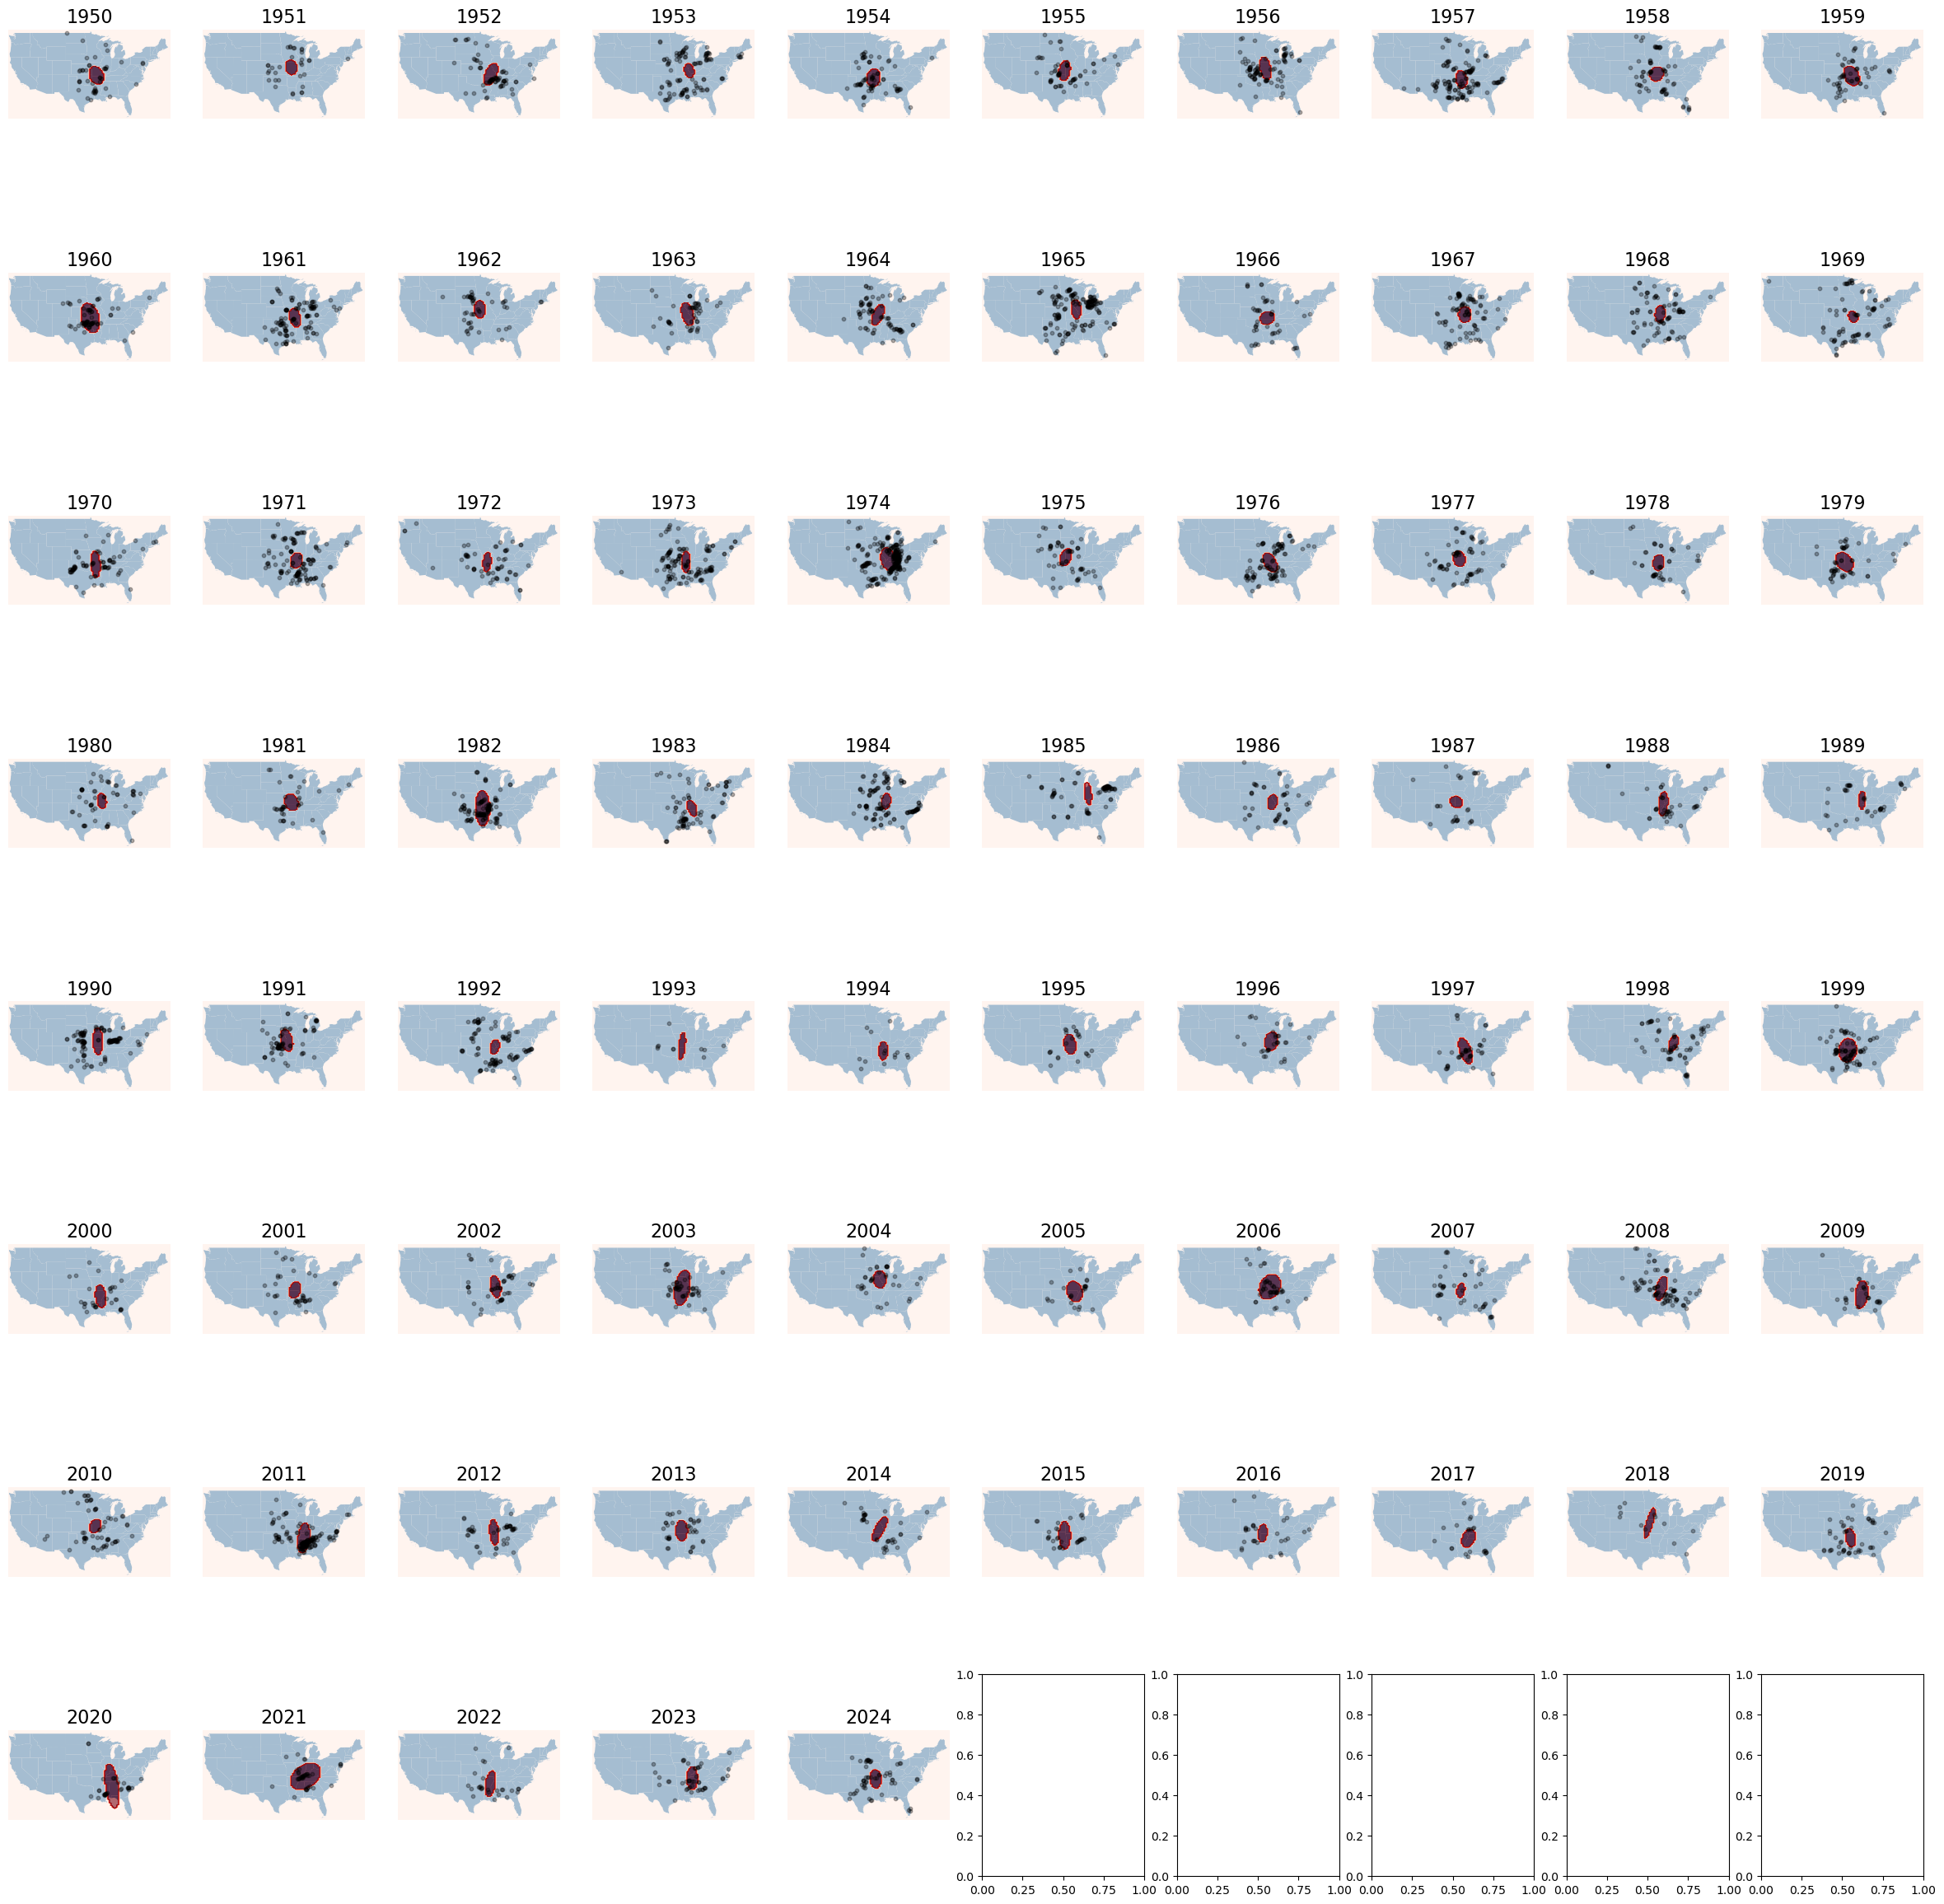

In [25]:
 ## This code block draws a contour plot of Tornado Alley for some selected years, for visualization's sake.
radius = 10
years = np.arange(1950,2025,1)

fig, axs = plt.subplots(8,10)
fig.set_size_inches(30,30)

xmin, xmax = -125, -66
ymin, ymax = 24, 50

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

for year in years:
    if year % 5 == 0:
        print('Processing year ' + str(year))
    plot_x = (year - 1950) % 10
    plot_y = (year - 1950) // 10

    tornado_alley = np.apply_along_axis(lambda x: tornado_alley_definer_gaussian(year,x,radius),0,positions).reshape(xx.shape)

    ax = axs[plot_y,plot_x]
    states.plot(ax=ax)

    contour = ax.contourf(xx, yy, tornado_alley, levels=10, cmap='Reds', alpha=0.6)

    tornado_x = tornado_df[tornado_df['year']==year]['begin_lon'].values
    tornado_y = tornado_df[tornado_df['year']==year]['begin_lat'].values
    ax.scatter(tornado_x, tornado_y, c='black', s=10, alpha=0.3)

    ax.set_title(str(year), fontsize=16)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_axis_off()

Let's see how well this plays with our weather station data in a given year.

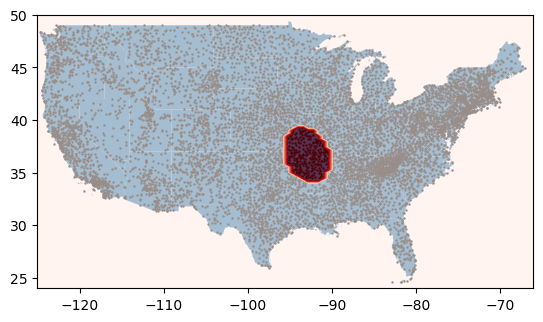

In [29]:
radius = 10
year=1950

states.plot()

xmin, xmax = -125, -66
ymin, ymax = 24, 50

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
tornado_alley = np.apply_along_axis(lambda x: tornado_alley_definer_gaussian(year,x,radius),0,positions).reshape(xx.shape)

plt.scatter(reduced_climate_df[reduced_climate_df['DATE']==year]['LONGITUDE'],reduced_climate_df[reduced_climate_df['DATE']==year]['LATITUDE'],c='black',s=2,marker='.')
plt.contourf(xx, yy, tornado_alley, levels=10, cmap='Reds', alpha=0.6)


plt.show()

### Labeling the Climate Data

In [30]:
radius = 10

gaussian_climate_df = reduced_climate_df.copy()
def tornado_alley_gaussian_identifier(row):
    '''
        Takes in a row of the dataframe and outputs a 1 if the point is in Tornado Alley, and a 0 otherwise.
    '''
    return tornado_alley_definer_gaussian(row['DATE'],np.array([row['LONGITUDE'],row['LATITUDE']]),radius)

gaussian_climate_df.loc[:,'tornado_alley'] = gaussian_climate_df.apply(tornado_alley_gaussian_identifier,axis=1)
gaussian_climate_df

,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,CLDD,DP01,DP10,DP1X,DT00,...,DX90,HTDD,PRCP,TMAX,TMIN,DSND,DSNW,SNOW,DYFG,tornado_alley
0,2009,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",184.3,115.0,54.0,1.0,34.0,...,3.0,NaN,549.7,12.07,0.45,NaN,NaN,NaN,NaN,0
1,2010,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",344.1,95.0,61.0,7.0,32.0,...,5.0,4465.7,755.1,12.91,1.72,NaN,NaN,NaN,NaN,0
2,2011,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",370.3,98.0,52.0,5.0,32.0,...,9.0,4621.8,632.0,13.00,1.25,NaN,NaN,NaN,NaN,0
3,2012,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",538.1,NaN,NaN,NaN,15.0,...,42.0,3489.0,NaN,16.33,3.17,NaN,NaN,NaN,NaN,0
4,2013,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",366.8,120.0,41.0,3.0,26.0,...,8.0,4345.7,547.5,12.06,0.62,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689112,2020,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",598.1,84.0,53.0,4.0,3.0,...,20.0,NaN,686.0,17.23,5.04,NaN,NaN,NaN,NaN,0
689113,2021,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",668.7,73.0,45.0,11.0,10.0,...,33.0,3304.9,792.6,17.83,5.58,NaN,NaN,NaN,NaN,0
689114,2022,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",724.6,73.0,40.0,6.0,13.0,...,50.0,3036.8,493.3,18.11,3.98,NaN,NaN,NaN,NaN,0
689115,2023,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",662.8,79.0,49.0,6.0,0.0,...,32.0,3237.8,611.5,18.53,5.33,NaN,NaN,NaN,NaN,0


In [31]:
gaussian_climate_df[gaussian_climate_df['tornado_alley'] == 1]

,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,CLDD,DP01,DP10,DP1X,DT00,...,DX90,HTDD,PRCP,TMAX,TMIN,DSND,DSNW,SNOW,DYFG,tornado_alley
2733,2018,40.395600,-95.66010,291.1,"BROWNVILLE 0.2 SW, NE US",NaN,96.0,63.0,13.0,NaN,...,NaN,NaN,985.8,NaN,NaN,NaN,NaN,NaN,NaN,1
3217,2018,40.099700,-95.80730,285.0,"DAWSON 2.5 SE, NE US",NaN,108.0,60.0,11.0,NaN,...,NaN,NaN,956.5,NaN,NaN,NaN,NaN,NaN,NaN,1
3241,2018,40.116400,-95.52560,303.0,"FALLS CITY 5.5 NE, NE US",NaN,111.0,61.0,10.0,NaN,...,NaN,NaN,926.4,NaN,NaN,NaN,NaN,NaN,NaN,1
3927,2009,33.019851,-86.92413,146.0,"WILTON 5.0 SSW, AL US",NaN,137.0,92.0,24.0,NaN,...,NaN,NaN,1953.7,NaN,NaN,NaN,NaN,NaN,NaN,1
3941,2020,33.802900,-86.56010,326.1,"SPRINGVILLE 5.3 WNW, AL US",NaN,134.0,98.0,26.0,NaN,...,NaN,NaN,2031.2,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688840,2004,41.613340,-90.59484,227.5,"DAVENPORT MUNICIPAL AIRPORT, IA US",311.1,131.0,63.0,6.0,12.0,...,0.0,3535.0,870.7,15.18,4.07,NaN,NaN,NaN,NaN,1
688910,2018,42.110610,-92.91635,295.3,"MARSHALLTOWN MUNICIPAL AIRPORT, IA US",542.3,NaN,NaN,NaN,18.0,...,15.0,3897.9,NaN,14.20,3.27,NaN,NaN,NaN,190.0,1
688938,2018,41.990450,-93.61852,281.5,"AMES MUNICIPAL AIRPORT, IA US",595.2,104.0,81.0,10.0,16.0,...,25.0,3783.4,1346.8,14.70,3.70,NaN,NaN,NaN,199.0,1
688976,2003,40.630640,-93.90045,345.5,"LAMONI MUNICIPAL AIRPORT, IA US",548.6,93.0,52.0,5.0,7.0,...,26.0,3330.3,669.7,16.27,4.78,NaN,NaN,NaN,NaN,1


### Some Additional EDA with this Labeling

In [ ]:
eda_df = gaussian_climate_df.copy()

### Creating the Testing and Training Sets

In [38]:
rand_data_fraction = .2
num_cv_splits = 4
random_state1 = 182
random_state2 = 17

train_year_df,test_year_df,train_rand_df,test_rand_df,train_cv_dfs,test_cv_dfs = create_all_test_train_splits(gaussian_climate_df,features_to_interpolate,test_years,rand_data_fraction,num_cv_splits,random_state1,random_state2)

Creating Specified Year Train-Test Split
Creating Randomized Train-Test Split
Creating Cross Validation Data Splits


### Applying Classification Models to the Cross Validation Data

In [39]:
num_neighbors = 9

knn_pipe = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=num_neighbors))
knn_scores = cross_val_score_custom(knn_pipe,train_cv_dfs,test_cv_dfs,f1_score,features)
print(knn_scores)

[0.24048156508653123, 0.2506310319227914, 0.23881945490137027, 0.24395341893102418]


In [40]:
logistic_pipe_no_reg = make_pipeline(StandardScaler(),LogisticRegression(penalty=None))
logistic_no_reg_scores = cross_val_score_custom(logistic_pipe_no_reg,train_cv_dfs,test_cv_dfs,f1_score,features)
print(logistic_no_reg_scores)

[0.0, 0.0, 0.0, 0.0]


In [41]:
logistic_pipe_reg = make_pipeline(StandardScaler(),LogisticRegression())
logistic_reg_scores = cross_val_score_custom(logistic_pipe_reg,train_cv_dfs,test_cv_dfs,f1_score,features)
print(logistic_reg_scores)

[0.0, 0.0, 0.0, 0.0]


In [42]:
svm_pipe_reg = make_pipeline(StandardScaler(),LinearSVC())
svm_reg_scores = cross_val_score_custom(svm_pipe_reg,train_cv_dfs,test_cv_dfs,f1_score,features)
print(svm_reg_scores)

[0.0, 0.0, 0.0, 0.0]


In [48]:
svm_rbf_kernel_pipe = make_pipeline(StandardScaler(),RBFSampler(gamma=1,random_state=1),LinearSVC())
svm_rbf_kernel_scores = cross_val_score_custom(svm_rbf_kernel_pipe,train_cv_dfs,test_cv_dfs,f1_score,features)
print(svm_rbf_kernel_scores)

[0.0, 0.0, 0.0, 0.0]


[0.2745383425816429, 0.274745269286754, 0.27408637873754155, 0.27403050909759236]


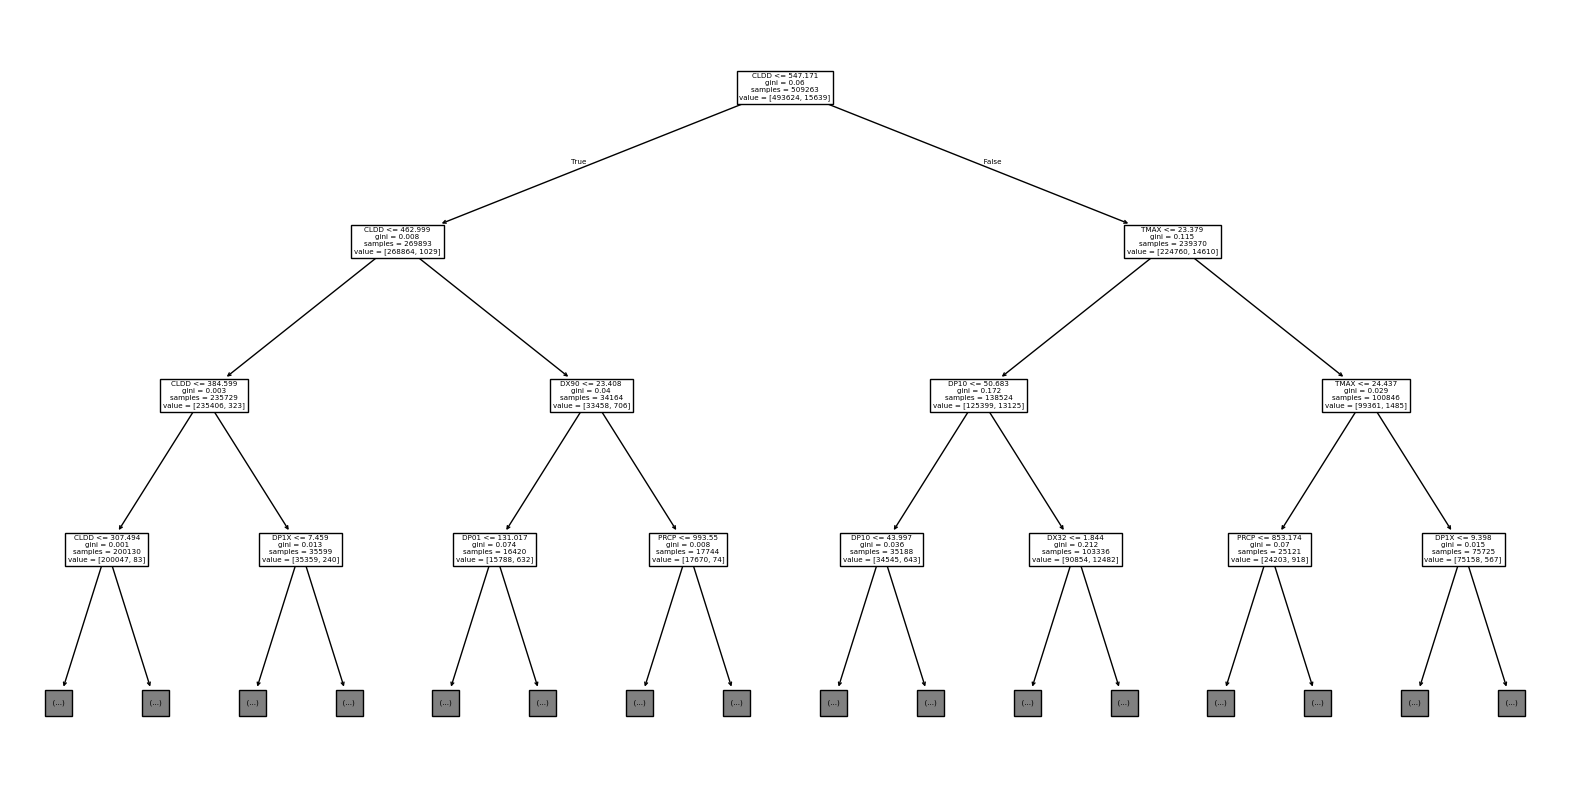

In [43]:
decision_tree_pipe = make_pipeline(tree.DecisionTreeClassifier())
decision_tree_scores = cross_val_score_custom(decision_tree_pipe,train_cv_dfs,test_cv_dfs,f1_score,features)
print(decision_tree_scores)
# Especially with the decision tree, it would be nice to see what's happening under the hood
plt.figure(figsize = (20,10))
tree.plot_tree(decision_tree_pipe[0],feature_names=features,max_depth=3)
plt.show()

In [44]:
num_trees = 20
random_forest_pipe = make_pipeline(RandomForestClassifier(n_estimators = num_trees))
random_forest_scores = cross_val_score_custom(random_forest_pipe,train_cv_dfs,test_cv_dfs,f1_score,features)
print(decision_tree_scores)

[0.2745383425816429, 0.274745269286754, 0.27408637873754155, 0.27403050909759236]


In [45]:
grad_boosting_pipe = make_pipeline(StandardScaler(),HistGradientBoostingClassifier())
grad_boosting_scores = cross_val_score_custom(grad_boosting_pipe,train_cv_dfs,test_cv_dfs,f1_score,features)
print(grad_boosting_scores)

[0.022080838323353294, 0.01791713325867861, 0.023433141156778872, 0.008674335281915897]


## A KDE-Based Definition of Tornado Alley

In [ ]:
tornado_df = pd.read_csv('all_tornadoes.csv')
# There are a very small subset (about 35) of strong tornadoes not having longitude or latitude values. These are removed now.
tornado_df = tornado_df[~tornado_df['begin_lat'].isnull()]
tornado_df = tornado_df[~tornado_df['begin_lon'].isnull()]

# Now, we also restrict ourselves to only working with strong tornadoes.
tornado_df = tornado_df[tornado_df['tor_f_scale'].isin(['F3','F4','F5'])]
tornado_df

,Unnamed: 0,state,begin_lat,begin_lon,tor_f_scale,year,year_bin
0,0,OKLAHOMA,35.1200,-99.2000,F3,1950,1948-1951
6,6,PENNSYLVANIA,40.2000,-76.1200,F3,1950,1948-1951
7,7,PENNSYLVANIA,40.2700,-76.0700,F3,1950,1948-1951
16,16,OKLAHOMA,34.8800,-99.2800,F3,1950,1948-1951
17,17,OKLAHOMA,35.0000,-99.2000,F3,1950,1948-1951
...,...,...,...,...,...,...,...
75183,75183,MISSISSIPPI,31.3773,-90.8606,F3,2024,2024-2027
75270,75270,OKLAHOMA,35.3640,-97.4380,F3,2024,2024-2027
75277,75277,OKLAHOMA,34.2910,-97.9690,F3,2024,2024-2027
75288,75288,OKLAHOMA,35.4000,-97.2420,F3,2024,2024-2027


To proceed, we will need a definition of Tornado Alley. No standard formal definition exists, so we'll work with the following idea:

_Tornado Alley consists of the portions of the US in which strong tornadoes (F3 or higher) occur with the highest frequency._

To obtain such a region we'll use a KDE method to mollify the empirical distribution of tornadoes. 

In [ ]:
from scipy.stats import gaussian_kde

def yearly_tornado_distributions(bandwidth, years):

    yearly_tornado_distributions = {}
    for year in years:
        year_tornadoes = tornado_df[tornado_df['year'] == year]
        xvals = year_tornadoes['begin_lon'].values
        yvals = year_tornadoes['begin_lat'].values

        if len(xvals) == 0:
            print('Warning: No data is present in the year ' + str(year))
        else:
            positions = np.vstack([xvals,yvals])

            dist = gaussian_kde(positions,bw_method=bandwidth)

            yearly_tornado_distributions[year] = dist
    
    return yearly_tornado_distributions


In using a KDE to define Tornado Alley, we have two highly significant parameters:
* The **bandwidth of the KDE**. A float, this parameter affects how wide a region around a given tornado is allocated 'tornado frequency' points from that tornado.
* The **required tornado frequency**. A float, this is the required number of 'tornado frequency' points required for a point to be considered inside of Tornado Alley.

In [ ]:
BANDWIDTH = .5
REQUIRED_FREQ = .01

In [ ]:
years = np.arange(1950,2025,1)

tornado_kdes = yearly_tornado_distributions(BANDWIDTH, years)

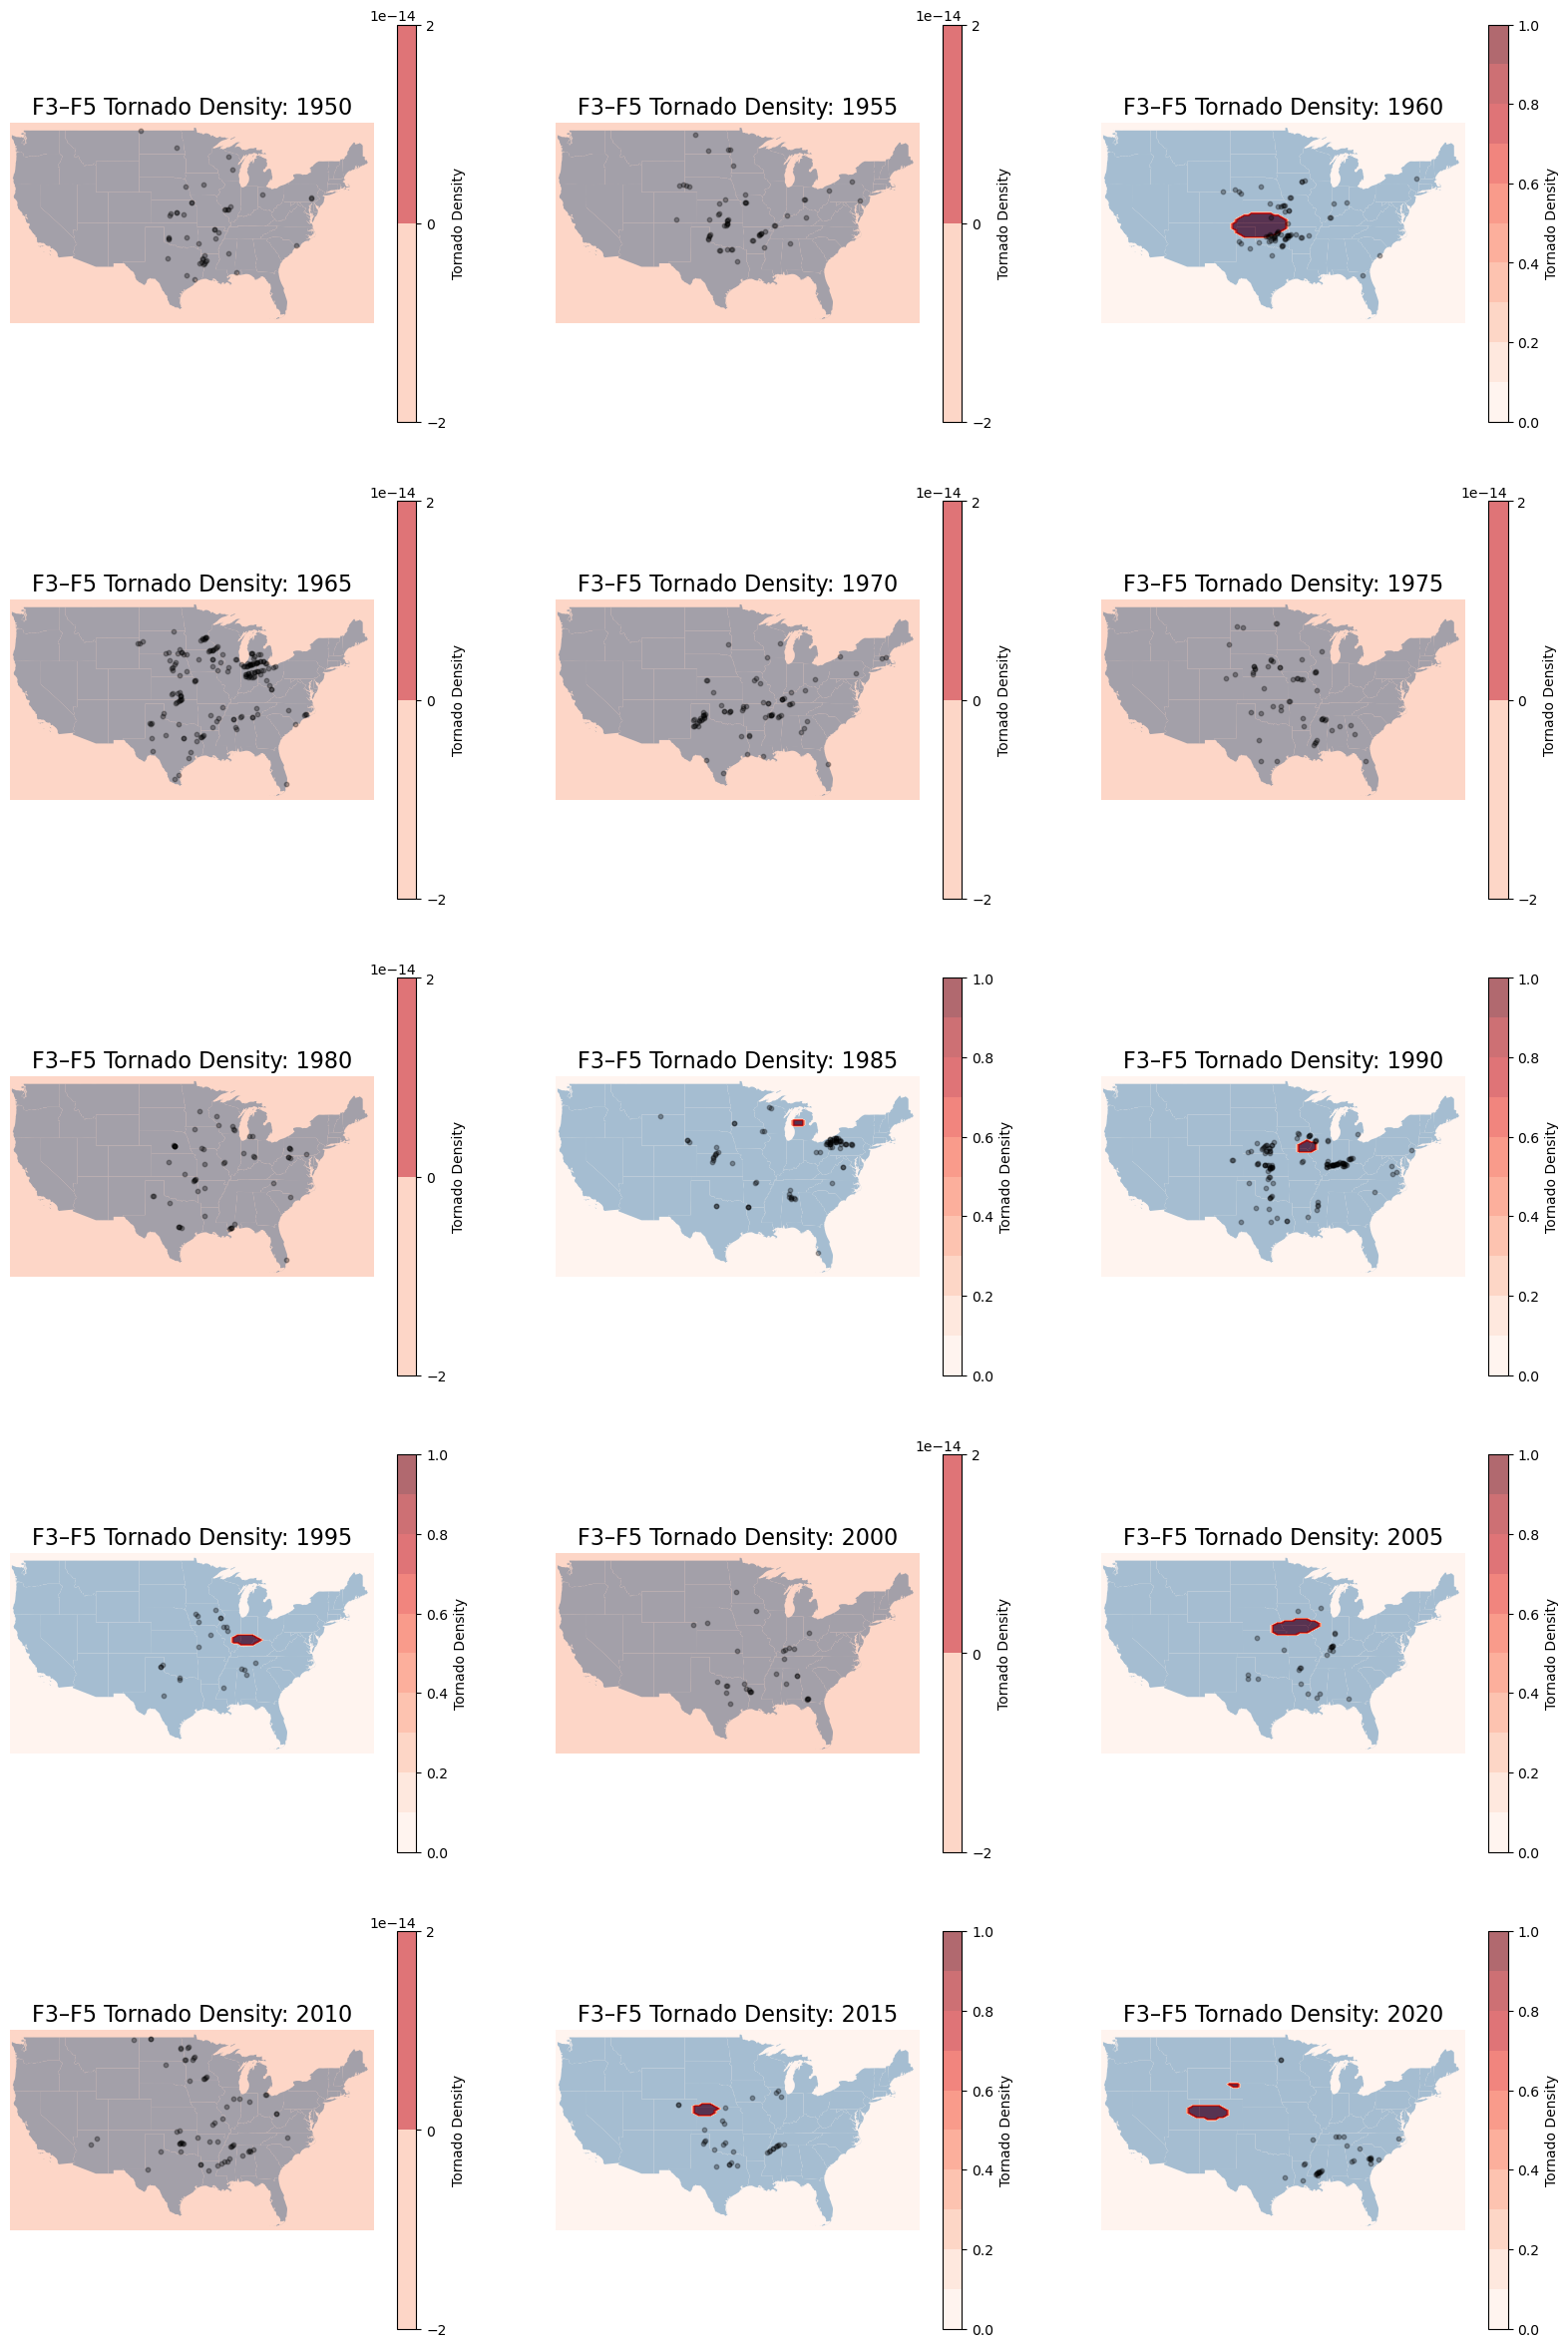

In [ ]:
 ## This code block draws a contour plot of the mollified empirical distribution for some selected years, for visualization's sake.

years = np.arange(1950,2025,5)

fig, axs = plt.subplots(5,3)
fig.set_size_inches(20,30)

xmin, xmax = -125, -66
ymin, ymax = 24, 50

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

for year in years:
    plot_x = ((year - 1950) // 5) % 3
    plot_y = ((year - 1950) // 5) // 3

    density = tornado_kdes[year](positions).reshape(xx.shape)
    tornado_alley = np.stack(np.vectorize(lambda x: int(x > REQUIRED_FREQ))(density),axis=1)

    ax = axs[plot_y,plot_x]
    states.plot(ax=ax)

    contour = ax.contourf(xx, yy, tornado_alley, levels=10, cmap='Reds', alpha=0.6)
    plt.colorbar(contour, ax=ax, label='Tornado Density')

    tornado_x = tornado_df[tornado_df['year']==year]['begin_lon'].values
    tornado_y = tornado_df[tornado_df['year']==year]['begin_lat'].values
    ax.scatter(tornado_x, tornado_y, c='black', s=10, alpha=0.3)

    ax.set_title("F3–F5 Tornado Density: " + str(year), fontsize=16)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_axis_off()

In [ ]:
def tornado_alley_classification(lat,lon,year):
    '''
        Given floats lat and lon representing the latitude and longitude of a point and an int year representing the year,
        outputs 1 if the point falls within tornado alley and a 0 otherwise.
    '''
    return int(tornado_kdes[year]([lon,lat])[0] > REQUIRED_FREQ)

def tornado_alley_calc(row):
    return tornado_alley_classification(row['LATITUDE'],row['LONGITUDE'],row['DATE'])

#climate_df['tornado_alley'] = climate_df.apply(tornado_alley_calc, axis=1)

#climate_df

,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,CDSD,CLDD,DP01,DP10,DP1X,...,TMAX,TMIN,DSND,DSNW,EMSD,EMSN,SNOW,DYFG,DYTS,tornado_alley
0,2009,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",184.3,184.3,115.0,54.0,1.0,...,12.07,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2010,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",344.1,344.1,95.0,61.0,7.0,...,12.91,1.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2011,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",370.3,370.3,98.0,52.0,5.0,...,13.00,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2012,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",538.1,538.1,NaN,NaN,NaN,...,16.33,3.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2013,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",366.8,366.8,120.0,41.0,3.0,...,12.06,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689112,2020,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",598.1,598.1,84.0,53.0,4.0,...,17.23,5.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
689113,2021,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",668.7,668.7,73.0,45.0,11.0,...,17.83,5.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
689114,2022,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",724.6,724.6,73.0,40.0,6.0,...,18.11,3.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
689115,2023,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",662.8,662.8,79.0,49.0,6.0,...,18.53,5.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## Old Material in this File that I Haven't Put Elsewhere Yet

The data here is fairly sparse, but perhaps >20 datapoints per state is sufficient, provided the points have a reasonable spread across the country.

Notice that, due to intricacies of the interpolation method, points near the boundary of the US are somewhat likely to be lost during interpolation. Given that Tornado Alley is somewhat inland, this is unlikely to cause any severe issues.

In [254]:
data_per_year = [[year, test_rand_df[test_rand_df['DATE'] == year].shape[0]] for year in non_test_years]
data_per_year = sorted(data_per_year, key = lambda x: x[1])

print(data_per_year)

[[1973, 1289], [1977, 1312], [1975, 1316], [1976, 1330], [1978, 1339], [1979, 1360], [1974, 1408], [1972, 1423], [1966, 1482], [1971, 1491], [1998, 1510], [1993, 1513], [1970, 1517], [1964, 1521], [1990, 1530], [1968, 1534], [1969, 1540], [1967, 1544], [1965, 1562], [1992, 1562], [1995, 1563], [1991, 1564], [1996, 1576], [1994, 1582], [1997, 1614], [1963, 1661], [1962, 1662], [2000, 1673], [1999, 1676], [1951, 1679], [1955, 1683], [1954, 1689], [2001, 1694], [1952, 1698], [1953, 1705], [1960, 1708], [1961, 1711], [1956, 1712], [1950, 1714], [2002, 1717], [1958, 1725], [1959, 1726], [1957, 1732], [2003, 1733], [2004, 1746], [2005, 1791], [2006, 1851], [2007, 1927], [2008, 2079], [2009, 2176], [2011, 2202], [2012, 2269], [2013, 2291], [2017, 2300], [2014, 2321], [2018, 2324], [2015, 2327], [2010, 2346], [2016, 2348], [2019, 2368]]


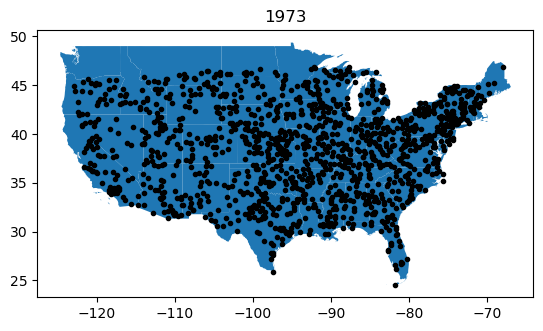

In [255]:
states.plot()

smallest_year = test_rand_df[test_rand_df['DATE'] == data_per_year[0][0]]
plt.scatter(smallest_year['LONGITUDE'],smallest_year['LATITUDE'],c='black',marker='.')
plt.title(str(data_per_year[0][0]))
plt.show()

### Setting up Cross Validation Sets for the Remaining Data

We'd like to set up cross-validation with the remaining data. Given our experience with taking the 20% of random data in the previous stage, we believe that using more than 4 splits at present would cause the mesh of the interpolation grid to become unreasonably large.